In [1]:
using Rays

# A view of a cube

### The basic setup

In [2]:
# Define a camera
camera = Rays.Camera()
camera.screen_res .= [500, 500]

# Define a cube at the origin
cube = Rays.Cube(zeros(Float32, 3), 1.0f0)

# Let the camera look towards the origin
from = [2.0, 2.0, 2.0]
to = zeros(3)
Rays.look_at!(camera, from, to)

# Compute ray intersections with the cube
intersection_data = Rays.shape_view(camera, cube)

# Generate an image from the ray intersections
# The brightness drops off with the distance to the camera
canvas_grayscale = Rays.cam_is_source(intersection_data.t);

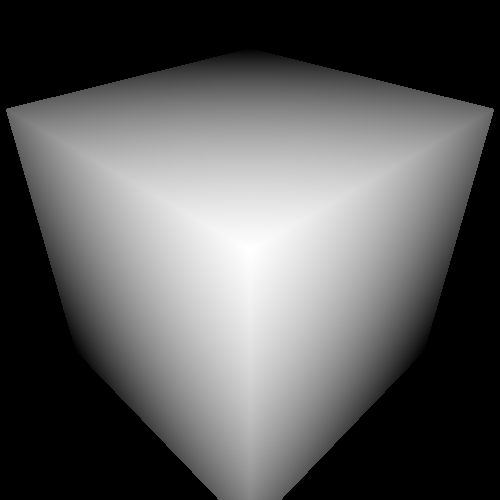

In [3]:
using Images: colorview, Gray

colorview(Gray, canvas_grayscale)

### Adding color

In [4]:
# Get ray intersections while collecting the data of the intersection dimension
data_variables = [:dim]
intersection_data = Rays.shape_view(camera, cube; data_variables)

# Assign the Julia colors the different intersection dimensions
julia_green = [0.22, 0.596, 0.149]
julia_purple = [0.584, 0.345, 0.698]
julia_red = [0.796, 0.235, 0.2]
julia_colors = hcat(julia_green, julia_purple, julia_red)

color = Rays.get_canvas(camera; color = true)
Rays.add_color!(color, julia_colors, intersection_data.dim)

# Apply color to the image
canvas_color = Rays.apply_color(canvas_grayscale, color);

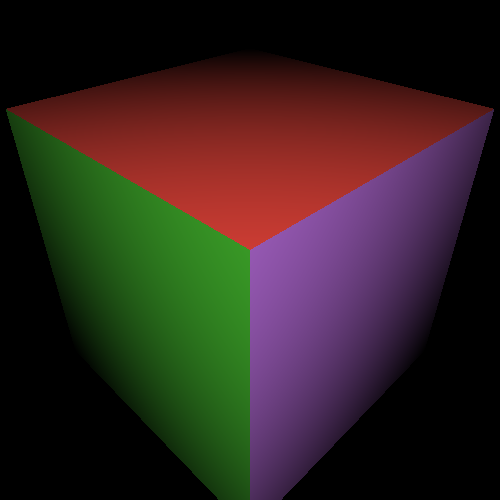

In [5]:
using Images: RGB, N0f8

canvas_RGB = RGB{N0f8}.([canvas_color[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

### Add depth of field

In [6]:
# This curve determines how the blurring depends on the distance to
# the camera
focus_curve(t) = 0.5 + 10 * abs(t - 3)

# Add depth of field
canvas_color = Rays.add_depth_of_field(canvas_color, intersection_data.t, focus_curve);

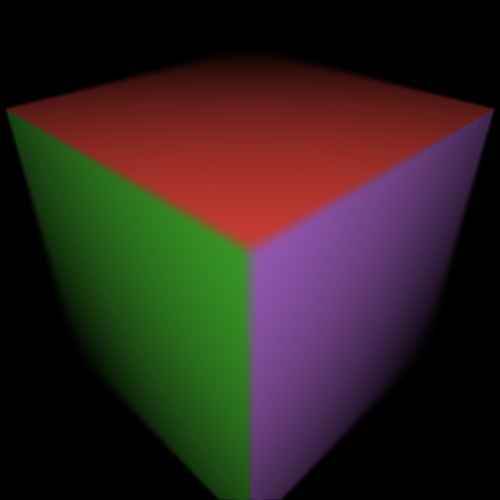

In [7]:
canvas_RGB = RGB{N0f8}.([canvas_color[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

### Replace the cube by a Menger sponge

In [8]:
# Get ray intersections while collecting the data of the intersection dimension
menger_sponge = Rays.Menger_sponge(zeros(Float32, 3), 1.0, 3)
intersection_data = Rays.shape_view(camera, menger_sponge; data_variables)

# Assign the Julia colors to the different intersection dimensions
color .= 0.0
Rays.add_color!(color, julia_colors, intersection_data.dim)

# Generate an image from the ray intersections
# The brightness drops off with the distance to the camera
canvas_grayscale = Rays.cam_is_source(intersection_data.t)

# Apply color to the image
canvas_color = Rays.apply_color(collect(canvas_grayscale), color)

# Add depth of field
canvas_color = Rays.add_depth_of_field(canvas_color, intersection_data.t, focus_curve);

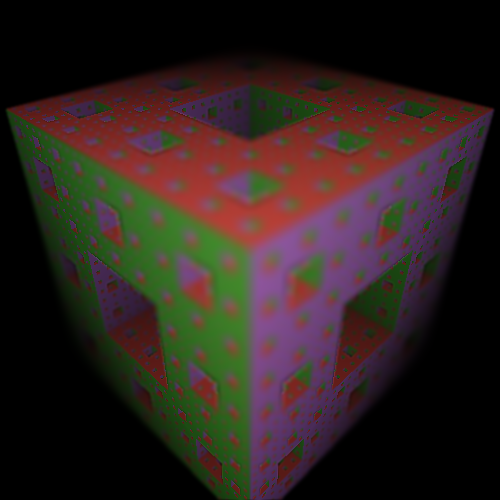

In [9]:
canvas_RGB = RGB{N0f8}.([canvas_color[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

### Add a camera warp

In [10]:
# Define warp function and assign it to the camera
function warp!(v)::Nothing
    v[3] = v[3] + 0.1 * sin(250 * v[2])
    v[1] = v[1] + 0.1 * sin(250 * v[2])
    return nothing
end
camera_warped = Rays.Camera([getfield(camera, f) for f in fieldnames(Rays.Camera)[1:end-1]]..., warp!)

# Get ray intersections while collecting the data of the intersection dimension
intersection_data = Rays.shape_view(camera_warped, menger_sponge; data_variables)

# Assign the Julia colors to the different intersection dimensions
color .= 0.0
Rays.add_color!(color, julia_colors, intersection_data.dim)

# Generate an image from the ray intersections
# The brightness drops off with the distance to the camera
canvas_grayscale = Rays.cam_is_source(intersection_data.t)

# Apply color to the image
canvas_color = Rays.apply_color(collect(canvas_grayscale), color)

# Add depth of field
canvas_color = Rays.add_depth_of_field(canvas_color, intersection_data.t, focus_curve);

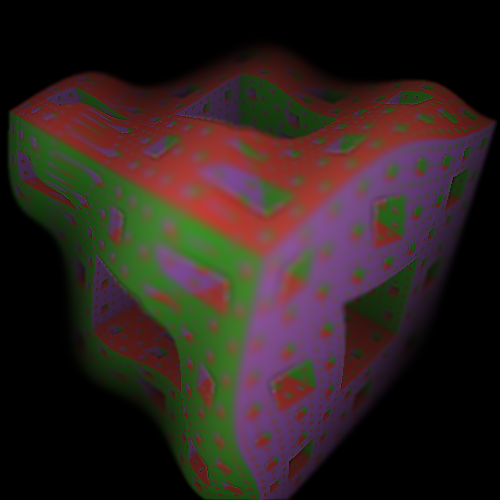

In [11]:
canvas_RGB = RGB{N0f8}.([canvas_color[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)

# Available shapes

### Default

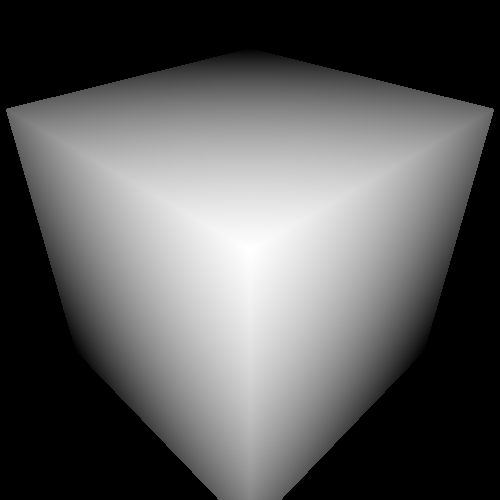

Rays.Cube{Float32}


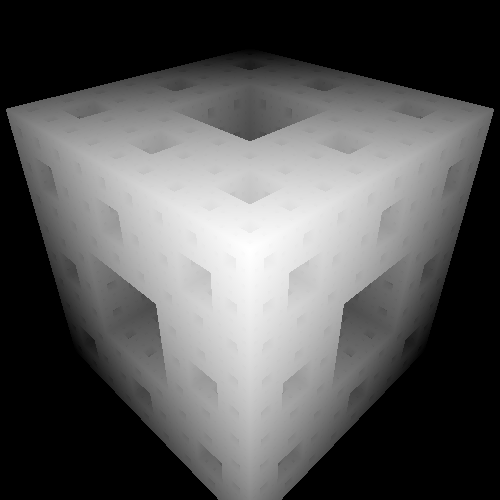

Rays.FractalShape{Float32, Int64, Rays.Cube{Float32}}


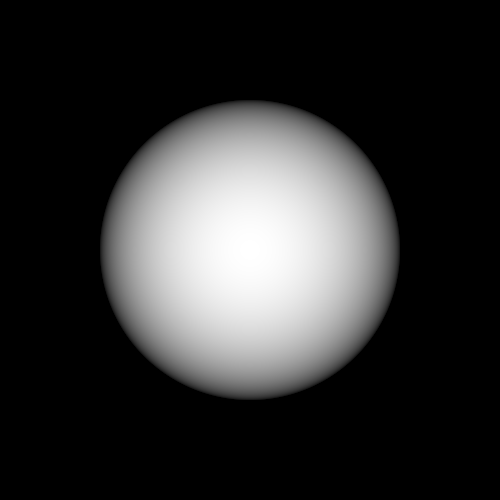

Rays.Sphere{Float32}

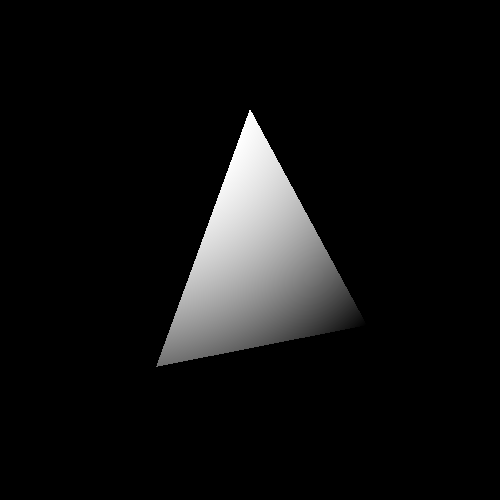

Rays.TriangleShape{Float32, Int64}


Rays.FractalShape{Float32, Int64, Rays.TriangleShape{

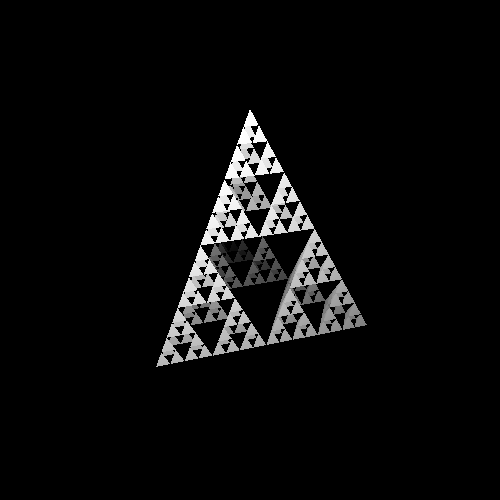

Float32}}


In [12]:
origin = zeros(Float32, 3)
R = 1.0f0

shapes = [
    Rays.Cube(origin, R),
    Rays.Menger_sponge(origin, R, 3),
    Rays.Sphere(origin, R),
    Rays.Tetrahedron(origin, R),
    Rays.Sierpinski_pyramid(origin, R, 3)
]

function simple_view(shape)
    intersection_data = Rays.shape_view(camera, shape)
    canvas = Rays.cam_is_source(intersection_data.t)
    println(typeof(shape))
    display(colorview(Gray, canvas))
end

for shape in shapes
    simple_view(shape)
end
    

### Custom

Define geometry

In [13]:
"""
Approximate a donut shape
"""
function Donut(R::F, r::F, n_θ::I, n_ϕ::I)::Rays.TriangleShape where {F <: AbstractFloat, I <: Integer}
    n_vertices = n_θ * n_ϕ
    n_faces = 2 * n_vertices

    Θ = range(0, 2π, n_θ + 1)[1:end-1]
    Φ = range(0, 2π, n_ϕ + 1)[1:end-1]

    vertices = zeros(F, n_vertices, 3)
    faces = zeros(I, 2 * n_θ * n_ϕ, 3)

    for (i, θ) in enumerate(Θ)
        for (j, ϕ) in enumerate(Φ) 

            vertex_idx_1 = (i - 1) * n_ϕ + j
            vertex_idx_2 = (i % n_θ) * n_ϕ + j
            vertex_idx_3 = (i - 1) * n_ϕ + j % n_ϕ + 1
            vertex_idx_4 = (i % n_θ) * n_ϕ + j % n_ϕ + 1

            vertices[vertex_idx_1, :] = [
                cos(θ) * (R + r*cos(ϕ)),
                sin(θ) * (R + r*cos(ϕ)),
                r * sin(ϕ)
            ]

            faces[vertex_idx_1, :] = [
                vertex_idx_1, 
                vertex_idx_2,
                vertex_idx_3,
            ]

            faces[n_vertices + vertex_idx_1, :] = [
                vertex_idx_4, 
                vertex_idx_2,
                vertex_idx_3,
            ]
        end
    end

    origin = zeros(F, 3)

    return Rays.TriangleShape{F, I}(
        vertices, 
        faces, 
        origin, 
        n_vertices,
        n_faces,
        false
    )
end

Donut

In [17]:
# Adjust camera
camera.screen_size .= [0.06, 0.1]
camera.screen_res .= [300, 500]
color = Rays.get_canvas(camera, color = true)

# Define donut shape
donut = Donut(1.0f0, 0.3f0, 10, 10)

# Compute intersections and collect intersection face data
data_variables = [:face]
intersection_data = Rays.shape_view(camera, donut; data_variables)

# Generate a random color per face
face_colors = (1.0 .+ rand(3, donut.n_faces))/2

# Generate color image
color .= 0.0
Rays.add_color!(color, face_colors, intersection_data.face)
canvas_grayscale = Rays.cam_is_source(intersection_data.t)
canvas_color = Rays.apply_color(canvas_grayscale, color);

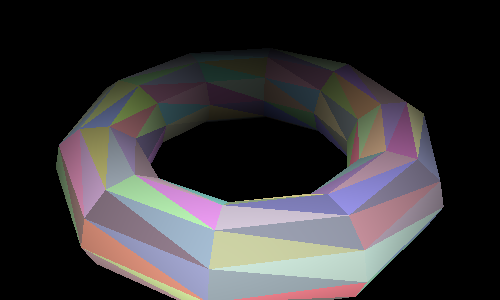

In [18]:
canvas_RGB = RGB{N0f8}.([canvas_color[channel, :, :] for channel = 1:3]...)
colorview(RGB, canvas_RGB)